Using autoencoder and TCN

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%tensorflow_version 2.x
from importlib.machinery import SourceFileLoader
somemodule = SourceFileLoader('tcn', '/content/drive/My Drive/Fax/Master Theses/keras-tcn-master/tcn/tcn.py').load_module()

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding
from sklearn import preprocessing

import os
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.python.keras.layers.core import Activation
from tensorflow.keras.models import Sequential,load_model, model_from_json

from tcn import TCN

In [0]:
# define paths
output_path = '/content/drive/My Drive/Fax/Master Theses/output-tcn-3-3'
model_path = output_path+'/mode.h5'
model_path_autoecoder = output_path+'/encoder_mode.h5'
data_path = '/content/drive/My Drive/Fax/Master Theses/Data/CMAPSSData/'

  

In [0]:
##################################
# Data Ingestion
##################################

# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(data_path+'train_FD001.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
test_df = pd.read_csv(data_path+'test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
truth_df = pd.read_csv(data_path+'RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
#######
# TRAIN set
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label columns for training data
# we will only make use of "label1" for binary classification, 
# while trying to answer the question: is a specific engine going to fail within w1 cycles?
w1 = 30
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)


In [0]:
######
# TEST set
######
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label columns w0 and w1 for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

#test_df.to_csv('../../Dataset/PredictiveManteinanceEngineValidation.csv', encoding='utf-8',index = None)


   id  cycle  setting1  setting2  ...  s19       s20       s21  cycle_norm
0   1      1  0.632184  0.750000  ...  0.0  0.558140  0.661834     0.00000
1   1      2  0.344828  0.250000  ...  0.0  0.682171  0.686827     0.00277
2   1      3  0.517241  0.583333  ...  0.0  0.728682  0.721348     0.00554
3   1      4  0.741379  0.500000  ...  0.0  0.666667  0.662110     0.00831
4   1      5  0.580460  0.500000  ...  0.0  0.658915  0.716377     0.01108

[5 rows x 27 columns]


In [0]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

train_x = train_df[sequence_cols].values.astype(np.float32)
print(train_x.shape)

(20631, 25)


In [0]:

def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [0]:
##################################
# Autoencoder
##################################

def autoencoder(data):

  n_samples = data.shape[0]
  nb_features = data.shape[1]

  input_d = Input(shape=(nb_features,))
  encoded = Dense(32, activation='relu')(input_d)
  encoded = Dense(16, activation='relu')(encoded)
  encoded = Dense(8, activation='relu')(encoded)

  decoded = Dense(16, activation='relu')(encoded)
  decoded = Dense(32, activation='relu')(decoded)
  decoded = Dense(nb_features, activation='sigmoid')(decoded)

  autoencoder = Model(input_d, decoded)
  autoencoder.compile('adam', 'mae')

  autoencoder.compile(loss= root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])
  autoencoder.summary()
  history = autoencoder.fit(data, data,
                  epochs=200,
                  verbose=2,
                  batch_size=256,
                  shuffle=True,
                  validation_data=(data, data),
                  callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(model_path_autoecoder,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

  return autoencoder

In [0]:
encoder_model = autoencoder(train_x)
encoded_data = encoder_model.predict(train_x,verbose=1, batch_size=200)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 25)                825   

In [0]:
#load encoder
def get_encoded_data(data, print_model_data):
  if os.path.isfile(model_path_autoecoder):

      # restore weights

      autoencoder_model = load_model(model_path_autoecoder,custom_objects={'r2_keras': r2_keras,'root_mean_squared_error': root_mean_squared_error })
      estimator_encoder = Model(inputs=autoencoder_model.inputs, outputs=autoencoder_model.layers[3].output)

      encoded_data = estimator_encoder.predict(data,verbose=1, batch_size=200)
      if print_model_data:
        print(estimator_encoder.summary())
      return encoded_data
    

In [0]:
##create encoded sequence data

# pick a window size
sequence_length = 64

encoded_cols = ['id', 's1', 's2', 's3','s4', 's5', 's6', 's7', 's8']
#get encoded data first
encoded_data = get_encoded_data(train_x, True)
# Convert the dictionary into DataFrame 
encoded_train = pd.DataFrame(encoded_data) 
  
# Using DataFrame.insert() to add a column 
encoded_train.insert(0, "id", train_df['id'], True) 
#add column names
encoded_train.columns = encoded_cols

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length):
    
    data_matrix = id_df[encoded_cols].values
    num_elements = data_matrix.shape[0]
    
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(encoded_train[encoded_train['id']==id], sequence_length)) 
          for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

20631/20631 [==============================] - 0s 7us/sample
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 1,496
Trainable params: 1,496
Non-trainable params: 0
_________________________________________________________________
None
(14231, 64, 9)


In [0]:


# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(14231, 1)

In [0]:
##output tcn 3

timesteps = seq_array.shape[1]
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]


i = Input(shape=(timesteps, nb_features))

m = TCN(nb_filters=9,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=True)(i)
m = TCN(nb_filters=5,dropout_rate = 0.2,dilations=[1, 2, 4, 8, 16, 32] ,return_sequences=False)(m)
m = Dense(1, activation='linear')(m)
model = Model(inputs=[i], outputs=[m])


model.summary()

model.compile('adam', 'mae')

model.compile(loss= root_mean_squared_error, optimizer='rmsprop',metrics=['mae',r2_keras,root_mean_squared_error])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 9)]           0         
_________________________________________________________________
tcn (TCN)                    (None, 64, 9)             2592      
_________________________________________________________________
tcn_1 (TCN)                  (None, 5)                 860       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6         
Total params: 3,458
Trainable params: 3,458
Non-trainable params: 0
_________________________________________________________________


In [0]:
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [#keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Train on 13519 samples, validate on 712 samples
Epoch 1/100
13519/13519 - 18s - loss: 2124.4290 - mae: 1324.7523 - r2_keras: -2.9118e+03 - root_mean_squared_error: 2114.2332 - val_loss: 52.7321 - val_mae: 43.3372 - val_r2_keras: -3.8223e-01 - val_root_mean_squared_error: 50.6070
Epoch 2/100
13519/13519 - 11s - loss: 204.5816 - mae: 135.9968 - r2_keras: -1.6799e+01 - root_mean_squared_error: 204.0004 - val_loss: 82.4931 - val_mae: 69.5197 - val_r2_keras: -2.4451e+00 - val_root_mean_squared_error: 79.5771
Epoch 3/100
13519/13519 - 11s - loss: 79.5649 - mae: 60.6319 - r2_keras: -1.2229e+00 - root_mean_squared_error: 79.4609 - val_loss: 58.7111 - val_mae: 48.6714 - val_r2_keras: -7.0110e-01 - val_root_mean_squared_error: 56.1582
Epoch 4/100
13519/13519 - 11s - loss: 62.3397 - mae: 48.1422 - r2_keras: -3.4398e-01 - root_mean_squared_error: 62.3579 - val_loss: 43.9704 - val_mae: 37.1148 - val_r2_keras: 0.0455 - val_root_mean_squared_error: 41.9565
Epoch 5/100
13519/13519 - 11s - loss: 54.570

dict_keys(['loss', 'mae', 'r2_keras', 'root_mean_squared_error', 'val_loss', 'val_mae', 'val_r2_keras', 'val_root_mean_squared_error'])


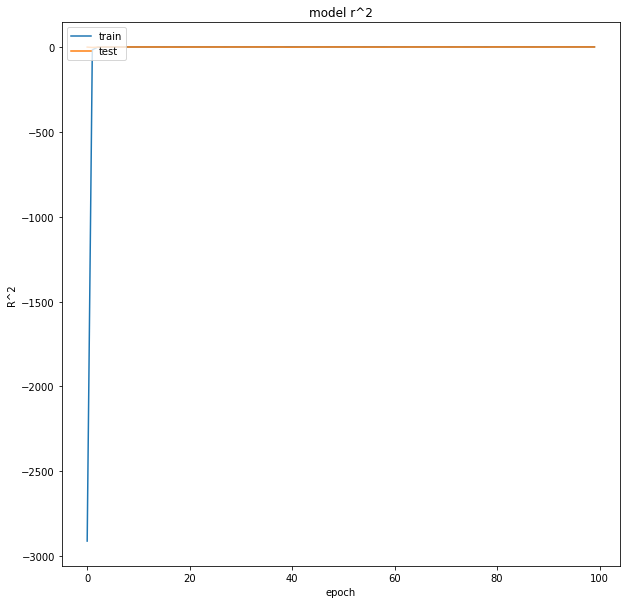

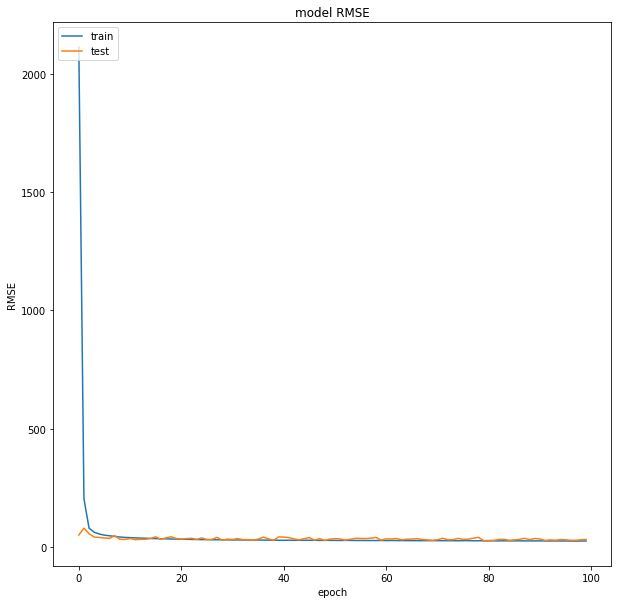

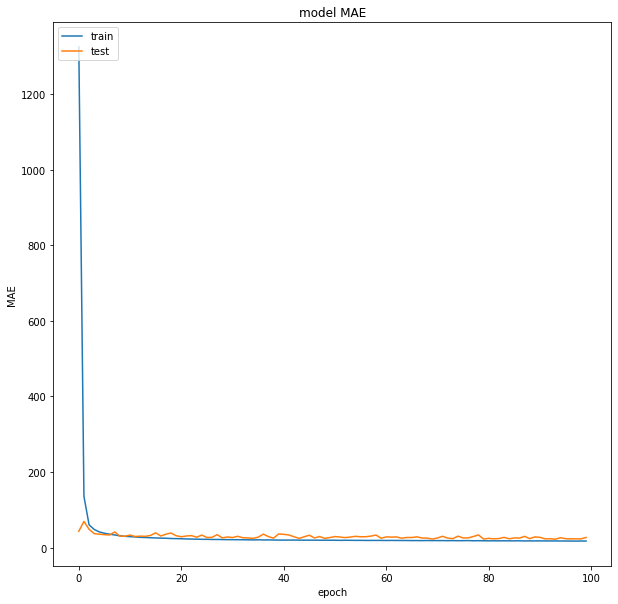

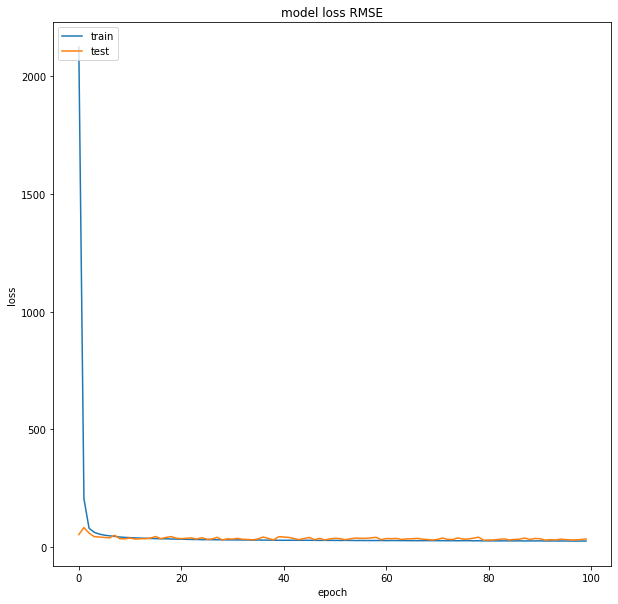

14231/14231 [==============================] - 4s 308us/sample - loss: 21.8552 - mae: 17.0974 - r2_keras: 0.7444 - root_mean_squared_error: 21.6486

MAE: 17.097360610961914

R^2: 0.7444366216659546
14231/14231 [==============================] - 5s 351us/sample


In [0]:

# list all data in history
print(history.history.keys())

# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_r2.png")

# summarize history for RMSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model RMSE')
plt.ylabel('RMSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_RMSE.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss RMSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig(output_path+"/model_regression_loss.png")

# training metrics

#encoded_data = get_encoded_data(seq_array, False)
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv(output_path+'/submit_train.csv', index = None)


In [0]:

test_x = test_df[sequence_cols].values.astype(np.float32)
print(test_x.shape)
#get encoded data first
encoded_data_test = get_encoded_data(test_x, True)
# Convert the dictionary into DataFrame 
encoded_test = pd.DataFrame(encoded_data_test) 
  
# Using DataFrame.insert() to add a column 
encoded_test.insert(0, "id", test_df['id'], True) 
#add column names
encoded_test.columns = encoded_cols

(13096, 25)
13096/13096 [==============================] - 0s 7us/sample
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 32)                832       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
Total params: 1,496
Trainable params: 1,496
Non-trainable params: 0
_________________________________________________________________
None


seq_array_test_last
(88, 64, 9)
(88, 1)
88/88 - 1s - loss: 22.1518 - mae: 15.3503 - r2_keras: 0.7057 - root_mean_squared_error: 21.9752

MAE: 15.35034465789795

R^2: 0.7056943774223328

RMSE: 21.97520637512207


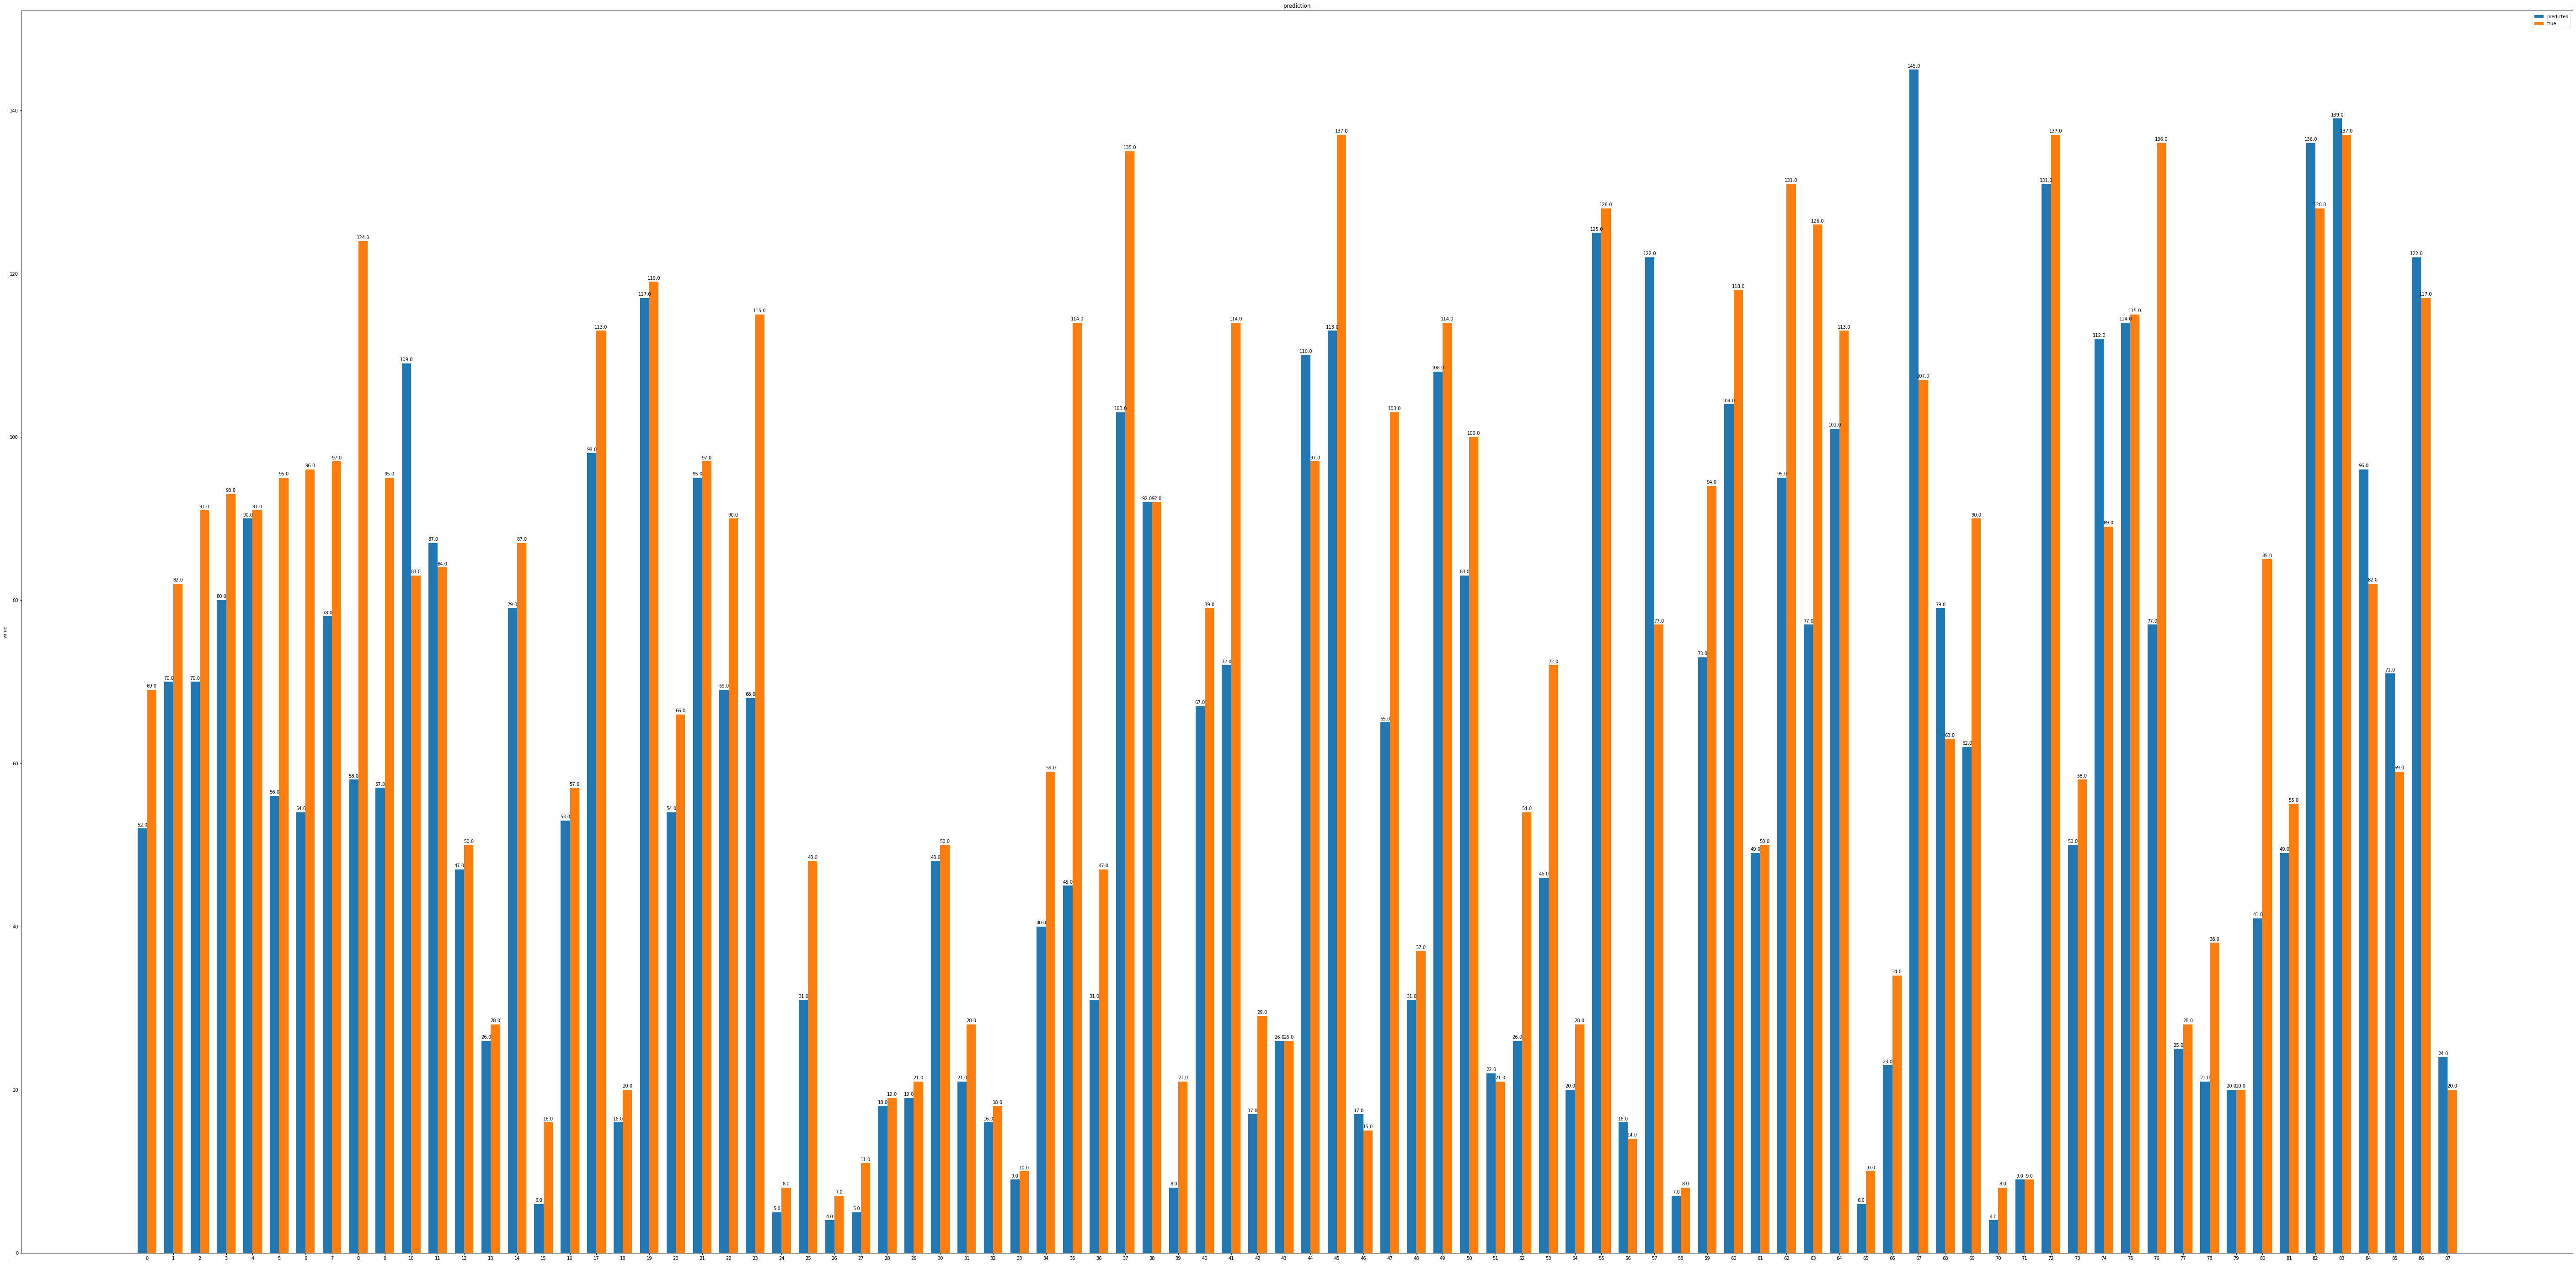

In [0]:
##################################
# EVALUATE ON TEST DATA
##################################

# We pick the last sequence for each id in the test data
seq_array_test_last = [encoded_test[encoded_test['id']==id][encoded_cols].values[-sequence_length:] 
                       for id in encoded_test['id'].unique() if len(encoded_test[encoded_test['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)


# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):

    # restore weights
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras,'root_mean_squared_error': root_mean_squared_error, 'TCN': TCN})

    
    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))
    print('\nRMSE: {}'.format(scores_test[3]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv(output_path+'/submit_test.csv', index = None)

    #######################
    # Plot in blue color the predicted data and in orange color the
    # actual data to verify visually the accuracy of the model.
        
    x = np.arange(len(y_pred_test))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(100, 50))
    rects1 = ax.bar(x - width/2, y_pred_test.flatten().round(), width, label='predicted')
    rects2 = ax.bar(x + width/2, y_true_test.flatten(), width, label='true')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('value')
    ax.set_title('prediction')
    ax.set_xticks(x)
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    autolabel(rects1)
    autolabel(rects2)

    plt.show()
    fig.savefig(output_path+"/model_verify_bar.png")